 (683, 10)


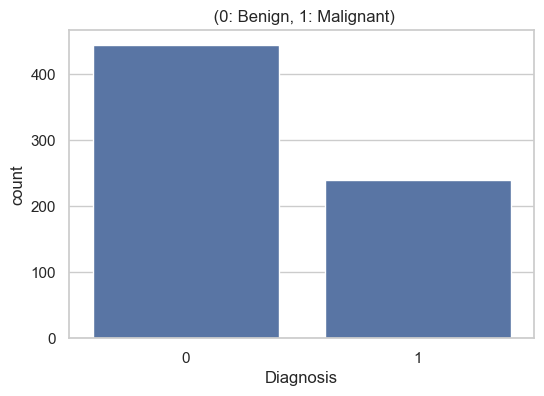

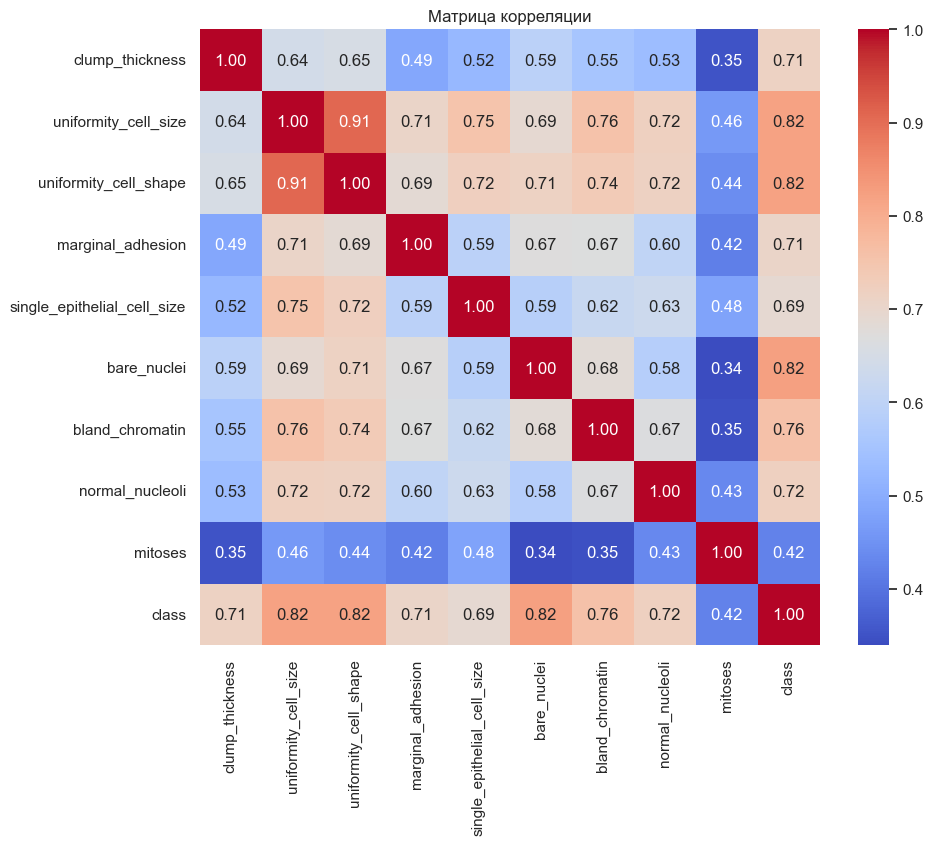


>>> Logistic Regression...
Accuracy (LR): 0.9609756097560975
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       133
           1       0.93      0.96      0.95        72

    accuracy                           0.96       205
   macro avg       0.95      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205



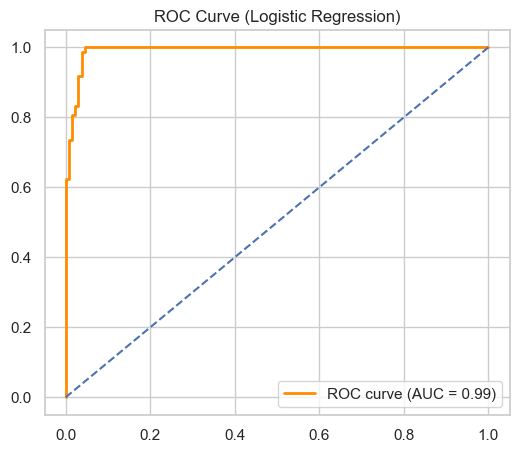

Fitting 5 folds for each of 18 candidates, totalling 90 fits
best_params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.9609756097560975
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       133
           1       0.93      0.96      0.95        72

    accuracy                           0.96       205
   macro avg       0.95      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205



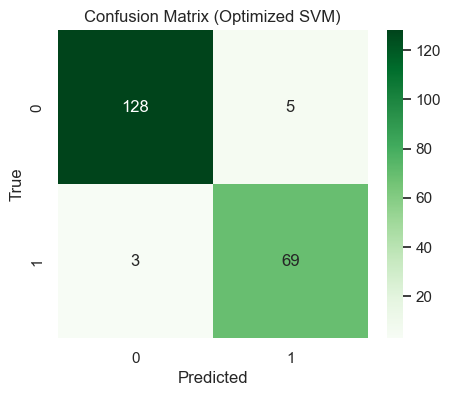

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_curve, auc)


sns.set(style="whitegrid")



column_names = ['id', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
                'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei',
                'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']


file_path = '../data/breast-cancer-wisconsin.csv' 

try:

    df = pd.read_csv(file_path, names=column_names, header=None)
    
   
    if str(df.iloc[0]['id']).lower() == 'id' or str(df.iloc[0]['id']).startswith('Sample'):
        df = df.iloc[1:]

  
    df = df.replace('?', np.nan)
    df = df.dropna()

 
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Удаление ID
    if 'id' in df.columns:
        df.drop('id', axis=1, inplace=True)

  
    df['class'] = df['class'].map({2: 0, 4: 1})
    
    print(f" {df.shape}")

except FileNotFoundError:
    print(f"{file_path}'. ")



# Баланс классов
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title(' (0: Benign, 1: Malignant)')
plt.xlabel('Diagnosis')
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()


X = df.drop('class', axis=1)
y = df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("\n>>> Logistic Regression...")
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Accuracy (LR):", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve (Logistic Regression)')
plt.legend()
plt.show()



param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}


grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"best_params: {grid.best_params_}")


best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Optimized SVM)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()
